# Multi-Input Text Explanation: Textual Entailment with Facebook BART


This notebook demonstrates how to get explanations for the output of the Facebook BART model trained on the mnli dataset and used for textual entailment. 

BART: https://huggingface.co/facebook/bart-large-mnli


In [1]:
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import shap
from datasets import load_dataset

### Load model and tokenizer

In [2]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli", use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# load dataset
dataset = load_dataset("snli")
snli_label_map = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
example_ind = 6
premise, hypothesis, label = ( dataset['train']['premise'][example_ind], 
                              dataset['train']['hypothesis'][example_ind], 
                              dataset['train']['label'][example_ind] )
print(premise)
print(hypothesis)
true_label = snli_label_map[label]
print('The true label is: {true_label}'.format(true_label=true_label))

Reusing dataset snli (C:\Users\v-jocelinsu\.cache\huggingface\datasets\snli\plain_text\1.0.0\bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c)


A boy is jumping on skateboard in the middle of a red bridge.
The boy skates down the sidewalk.
The true label is: contradiction


In [5]:
# test model
input_ids = tokenizer.encode(premise, hypothesis, return_tensors='pt')
logits = model(input_ids)[0]
probs = logits.softmax(dim=1)

bart_label_map = {0: 'contradiction', 1: 'neutral', 2: 'entailment'}
for i, lab in bart_label_map.items():
    print('{lab} probability: {prob:0.2f}%'.format(lab=lab, prob=probs[0][i] * 100))


contradiction probability: 99.95%
neutral probability: 0.03%
entailment probability: 0.02%


## Run shap values

In [6]:
import scipy as sp
import torch

# wrapper function for model
# takes in masked string which is in the form: premise <separator token(s)> hypothesis 
def f(x): 
    outputs = []
    for _x in x:
        encoding = torch.tensor([tokenizer.encode(_x)])
        output = model(encoding)[0].detach().cpu().numpy() 
        outputs.append(output[0])
    outputs = np.array(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [7]:
# Construct explainer
bart_labels = ['contradiction', 'entailment', 'neutral']    
explainer = shap.Explainer(f, tokenizer, output_names=bart_labels)

# encode then decode premise, hypothesis to get concatenated sentences
encoded = tokenizer(premise, hypothesis)['input_ids'][1:-1] # ignore the start and end tokens, since tokenizer will naturally add them
decoded = tokenizer.decode(encoded)
print(decoded)

A boy is jumping on skateboard in the middle of a red bridge.</s></s>The boy skates down the sidewalk.


explainers.Partition is still in an alpha state, so use with caution...


In [8]:
shap_values = explainer([decoded]) # wrap input in list, otherwise zip would iterate across letters
print(shap_values)

Partition explainer: 2it [00:16, 16.67s/it]                                                                            

shap values
.values =
array([[[-0.03363032,  0.0686294 , -0.19693293],
        [-0.03363032,  0.0686294 , -0.19693293],
        [-0.03363032,  0.0686294 , -0.19693293],
        [-0.03363032,  0.0686294 , -0.19693293],
        [-0.35364948,  0.24342118,  0.05151178],
        [-0.35364948,  0.24342118,  0.05151178],
        [-0.35364948,  0.24342118,  0.05151178],
        [-0.35364948,  0.24342118,  0.05151178],
        [ 0.49053347, -0.37554936, -0.49134417],
        [ 0.49053347, -0.37554936, -0.49134417],
        [ 0.49053347, -0.37554936, -0.49134417],
        [ 0.49053347, -0.37554936, -0.49134417],
        [ 0.56363714, -0.45293712, -0.46598371],
        [ 0.56363714, -0.45293712, -0.46598371],
        [ 0.56363714, -0.45293712, -0.46598371],
        [ 0.56363714, -0.45293712, -0.46598371],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.2765862 , -0.33341086, -0.00374915],
        [ 0.2765862 , -0.33341086, -0.00374915],
        [ 0.2765862 , -0.33341086, -0.00374915]

## Explanation Visualization

In [9]:
shap.plots.text(shap_values)

,A boy is,jumping on skate board,in the middle of,a red bridge .,</s>,</s> The boy sk,ates down the sidewalk,.,
contradiction,-0.135,-1.415,1.962,2.255,0.0,1.106,5.048,0.496,0.0
entailment,0.275,0.974,-1.502,-1.812,0.0,-1.334,-3.709,-0.243,0.0
neutral,-0.788,0.206,-1.965,-1.864,0.0,-0.015,-4.19,-0.24,0.0


## Input Partition Tree - Dendrogram

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [11]:
Z = shap_values[0].abs.clustering
Z[-1][2] = Z[-2][2] + 10 # last row's distance is extremely large, so make it a more reasonable value
print(Z)

[[ 0.  1. 12.  2.]
 [ 2.  3. 12.  2.]
 [ 4.  5. 12.  2.]
 [ 6.  7. 12.  2.]
 [ 8.  9. 12.  2.]
 [10. 11. 12.  2.]
 [12. 13. 12.  2.]
 [17. 18. 12.  2.]
 [19. 20. 12.  2.]
 [21. 22. 12.  2.]
 [23. 24. 12.  2.]
 [33. 14. 13.  3.]
 [27. 28. 14.  4.]
 [29. 30. 14.  4.]
 [31. 32. 14.  4.]
 [34. 35. 14.  4.]
 [36. 37. 14.  4.]
 [38. 15. 15.  4.]
 [43. 25. 16.  5.]
 [39. 40. 18.  8.]
 [41. 44. 18.  8.]
 [42. 45. 19.  9.]
 [46. 47. 26. 16.]
 [48. 26. 40. 10.]
 [49. 16. 47. 17.]
 [51. 50. 57. 27.]]


In [12]:
# clean labels of unusal characters
labels_arr = []
for token in shap_values[0].data:
    if token[0] == 'Ġ':
        labels_arr.append(token[1:])
    else:
        labels_arr.append(token)
print(labels_arr)


[' ', 'A ', 'boy ', 'is ', 'jumping ', 'on ', 'skate ', 'board ', 'in ', 'the ', 'middle ', 'of ', 'a ', 'red ', 'bridge ', '. ', '</s> ', '</s> ', 'The ', 'boy ', 'sk ', 'ates ', 'down ', 'the ', 'sidewalk ', '. ', ' ']


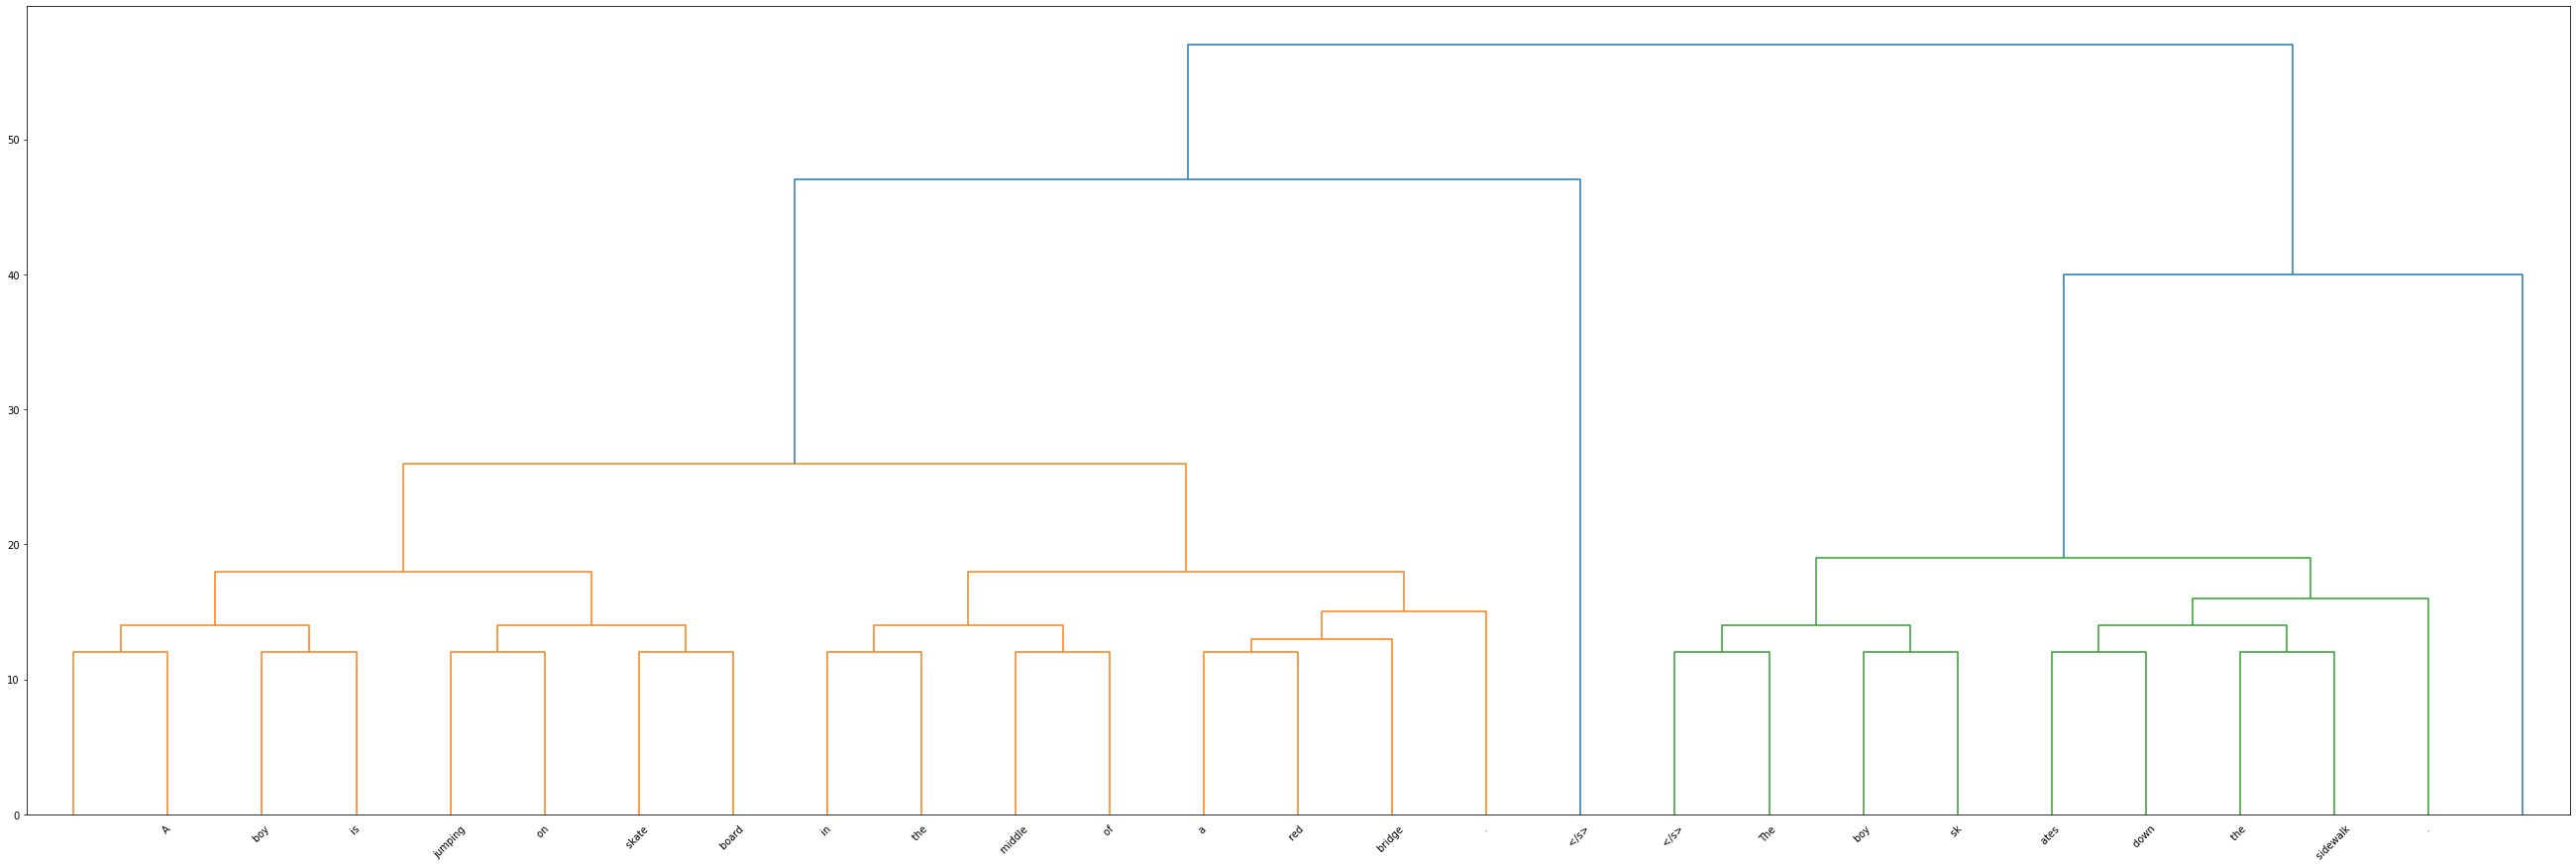

In [13]:
fig = plt.figure(figsize=(len(Z) + 20, 15))
dn = dendrogram(Z, labels=labels_arr)
plt.show()

## Benchmarking

In [14]:
sort_order = 'positive'
perturbation = 'keep'

In [15]:
from shap import benchmark

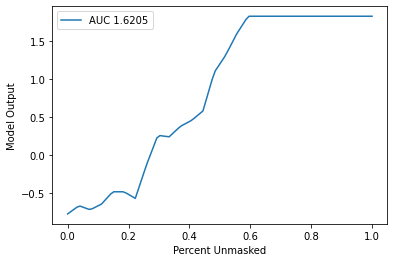

In [16]:
sper = benchmark.perturbation.SequentialPerturbation(explainer.model, explainer.masker, sort_order, perturbation)
xs, ys, auc = sper.model_score(shap_values, [decoded])
sper.plot(xs, ys, auc)